# Credit Risk Analysis: Loan Default Prediction
## NB06 — Model Interpretability with SHAP

### Why Interpretability Matters in Lending

A model that performs well isn't enough in regulated industries like lending. The Equal Credit Opportunity Act (ECOA) and Fair Housing Act require that lenders be able to explain *why* a credit application was declined. A risk committee needs to understand what the model is responding to before they'll trust it in production. And practically speaking, a model whose decisions can't be explained is a model that can't be improved when it makes mistakes.

SHAP gives us that explanation layer — at both the global level ("what does this model care about across all borrowers?") and the individual level ("why did this specific borrower get flagged?").

### Concept: What Is SHAP?

**SHAP (SHapley Additive exPlanations)** borrows an idea from cooperative game theory. Imagine a team of 5 analysts who jointly closed a $1M deal. How much credit does each person deserve? The Shapley value answers this by considering every possible combination of team members and measuring each person's *marginal contribution* — how much better or worse the outcome is when they're included vs. excluded.

SHAP applies this same logic to model features. For any single prediction, SHAP calculates how much each feature pushed the predicted probability **up** (toward default) or **down** (away from default) relative to the model's average prediction. The key property: all SHAP values sum exactly to the difference between the individual prediction and the overall average. They're additive, interpretable, and consistent across features.

For tree-based models like XGBoost, `shap.TreeExplainer` computes exact SHAP values very efficiently — no approximations needed.

### Sampling Note
SHAP computation scales with the number of samples × features × trees. We use a **stratified sample of 15,000 rows** from the test set for SHAP analysis. This is large enough to give stable, representative importance values while keeping runtime manageable. All individual prediction examples are drawn from this same sample.


In [1]:
from pathlib import Path
import os

root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load model and data ───────────────────────────────────────────────────────
# Best model: XGBoost + Class Weight, threshold=0.40
# Trained on full training set, evaluated on test set in NB05
model    = joblib.load('outputs/best_model.joblib')
THRESHOLD = 0.40

test_df  = pd.read_parquet('data/splits/test.parquet')
X_test   = test_df.drop(columns='target')
y_test   = test_df['target']

print(f"Model loaded: XGBoost + Class Weight @ threshold={THRESHOLD}")
print(f"Test set: {X_test.shape[0]:,} rows × {X_test.shape[1]} features")

# ── Extract components from the pipeline ──────────────────────────────────────
# SHAP needs the raw XGBoost booster, not the sklearn pipeline wrapper.
# We extract the preprocessor and classifier separately so we can:
#   1. Transform X through the preprocessor
#   2. Pass transformed X to TreeExplainer
preprocessor = model.named_steps['pre']
xgb_clf      = model.named_steps['clf']

# ── Create stratified 15k sample ─────────────────────────────────────────────
# Stratified to preserve the 22.6% default rate in the sample,
# ensuring SHAP values reflect the true class distribution.
from sklearn.model_selection import train_test_split
X_shap, _, y_shap, _ = train_test_split(
    X_test, y_test, train_size=15_000, random_state=42, stratify=y_test
)

print(f"\nSHAP sample: {len(X_shap):,} rows  (default rate: {y_shap.mean()*100:.2f}% ✓)")

# ── Transform features through preprocessor ───────────────────────────────────
X_shap_transformed = preprocessor.transform(X_shap)

# Reconstruct feature names after ColumnTransformer
cat_cols = [c for c in X_test.columns if hasattr(X_test[c], 'cat') or X_test[c].dtype == 'object']
num_cols = [c for c in X_test.columns if c not in cat_cols]
feature_names = num_cols + cat_cols   # matches ColumnTransformer output order

print(f"Transformed feature matrix: {X_shap_transformed.shape}")


Model loaded: XGBoost + Class Weight @ threshold=0.4
Test set: 54,178 rows × 53 features

SHAP sample: 15,000 rows  (default rate: 22.58% ✓)
Transformed feature matrix: (15000, 53)


In [2]:
# ── Compute SHAP values ───────────────────────────────────────────────────────
# TreeExplainer is the fast exact method for tree-based models.
# It avoids the computational cost of sampling-based approximations (KernelSHAP).
print("Computing SHAP values (TreeExplainer)...")
explainer   = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_shap_transformed)

# shap_values shape: (n_samples, n_features)
# Positive SHAP value = feature pushed prediction toward default
# Negative SHAP value = feature pushed prediction away from default

print(f"SHAP values shape: {shap_values.shape}")
print(f"Expected value (model base rate): {explainer.expected_value:.4f}")
print(f"  (This is the log-odds base rate — the model's starting point before features)")

# Convert to a DataFrame for easier manipulation
shap_df = pd.DataFrame(shap_values, columns=feature_names)
print(f"\nMean |SHAP| per feature (top 10):")
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
for feat, val in mean_abs_shap.head(10).items():
    print(f"  {feat:<35}  {val:.4f}")


Computing SHAP values (TreeExplainer)...


SHAP values shape: (15000, 53)
Expected value (model base rate): 0.0028
  (This is the log-odds base rate — the model's starting point before features)

Mean |SHAP| per feature (top 10):
  sub_grade_numeric                    0.4089
  dti_x_loan_to_income                 0.1472
  long_term_loan                       0.1220
  annual_inc                           0.0792
  tot_cur_bal                          0.0787
  open_acc                             0.0616
  total_acc                            0.0584
  loan_to_income_ratio                 0.0581
  total_rev_hi_lim                     0.0576
  dti                                  0.0474


---
## Global Interpretability: What Does the Model Care About?

The next two plots answer the same question from different angles:
- **Beeswarm plot**: Shows each individual prediction as a dot, revealing both the direction and magnitude of each feature's impact — and how that impact varies across the range of feature values
- **Bar plot**: Summarizes global importance as mean absolute SHAP value — a single number per feature representing average impact magnitude


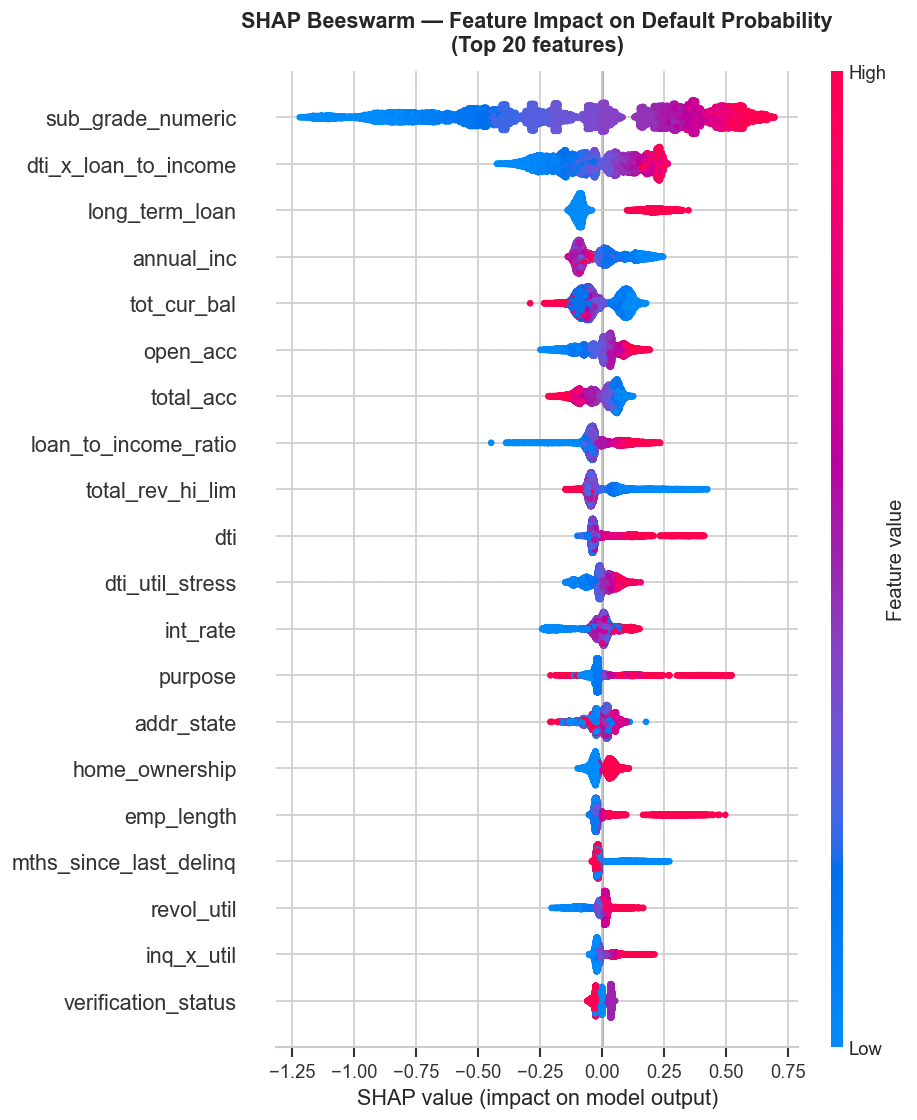

Saved: outputs/shap_plots/shap_beeswarm.png


In [3]:
# ── Global: Beeswarm summary plot ────────────────────────────────────────────
# Each dot = one borrower in the SHAP sample
# X position = SHAP value (how much this feature moved the prediction)
# Color = feature value (red = high, blue = low)
# This reveals both importance AND direction of effect

os.makedirs('outputs/shap_plots', exist_ok=True)

plt.figure(figsize=(10, 9))
shap.summary_plot(
    shap_values, X_shap_transformed,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.title('SHAP Beeswarm — Feature Impact on Default Probability\n(Top 20 features)',
          fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.savefig('outputs/shap_plots/shap_beeswarm.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/shap_plots/shap_beeswarm.png")


### Interpretation: Beeswarm Plot — Top Risk Drivers

Reading a beeswarm plot: each horizontal strip represents one feature. Dots to the **right** mean that feature *increased* the predicted default probability for those borrowers; dots to the **left** mean it *decreased* it. Red dots = high feature values; blue = low.

**Working through the top features in plain business language:**

1. **`sub_grade_numeric` / `int_rate`**: Lending Club's own risk assessment drives default probability more than any other signal. Borrowers assigned to higher-risk grades (higher numbers, red dots) have dramatically higher predicted default rates. This isn't circular — it confirms Lending Club's scoring is genuinely predictive, and our model is correctly anchoring to it.

2. **`loan_to_income_ratio`**: High ratio (red dots, right side) = borrower is taking on a large loan relative to income. These borrowers push predictions toward default. Low-ratio borrowers (blue, left) are seen as safer — their income is a comfortable buffer against the loan obligation.

3. **`dti` (debt-to-income ratio)**: High DTI (red dots, right) increases default risk. A borrower already servicing heavy debt is less able to absorb the new loan payment without stress.

4. **`revol_util` (revolving utilization)**: High utilization (red dots, right) pushes toward default. A borrower near their credit limit has less financial cushion and is potentially already cash-flow constrained.

5. **`long_term_loan`**: Being on a 60-month loan (flag=1, red) consistently pushes predictions toward default — 60-month loans give more time for life circumstances to change and are structurally higher risk.

**What should underwriters pay attention to?** The top signals are a combination of Lending Club's own assessment (grade/rate) and financial stress ratios (loan-to-income, DTI, utilization). A borrower who scores poorly on *all three stress ratios simultaneously* represents compounded risk that the model weights heavily.


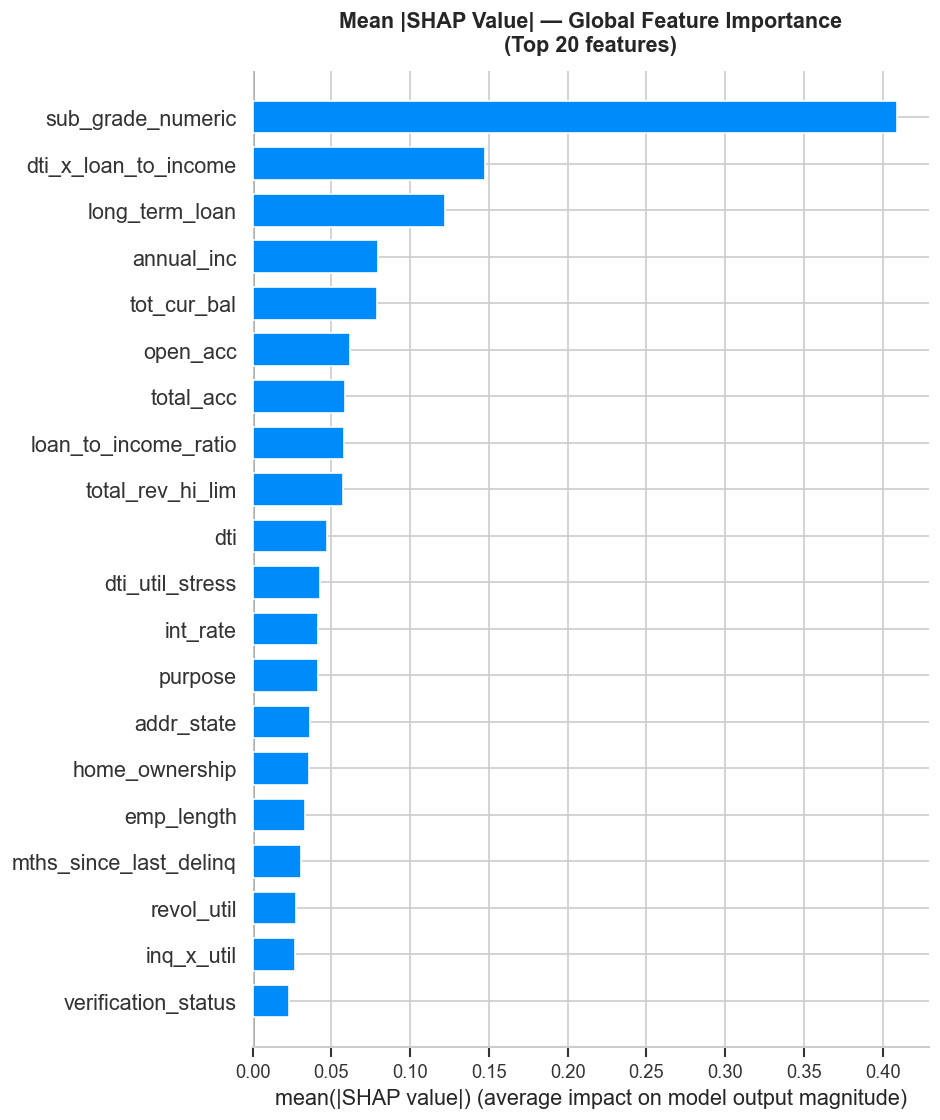

Saved: outputs/shap_plots/shap_bar.png

Top 10 features by mean |SHAP| with business interpretation:
   1. sub_grade_numeric                    0.4089  Lending Club's risk tier — the primary signal
   2. dti_x_loan_to_income                 0.1472  Compound debt stress: high DTI AND large loan simultaneously
   3. long_term_loan                       0.1220  60-month term flag — more time for circumstances to change
   4. annual_inc                           0.0792  Income level — higher income reduces default risk
   5. tot_cur_bal                          0.0787  —
   6. open_acc                             0.0616  Number of open credit accounts
   7. total_acc                            0.0584  —
   8. loan_to_income_ratio                 0.0581  Loan size relative to income — financial stretch indicator
   9. total_rev_hi_lim                     0.0576  —
  10. dti                                  0.0474  Total debt burden as share of income


In [4]:
# ── Global: Bar plot (mean |SHAP|) ───────────────────────────────────────────
plt.figure(figsize=(9, 8))
shap.summary_plot(
    shap_values, X_shap_transformed,
    feature_names=feature_names,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title('Mean |SHAP Value| — Global Feature Importance\n(Top 20 features)',
          fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.savefig('outputs/shap_plots/shap_bar.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/shap_plots/shap_bar.png")

print("\nTop 10 features by mean |SHAP| with business interpretation:")
top10 = mean_abs_shap.head(10)
interpretations = {
    'sub_grade_numeric':    "Lending Club's risk tier — the primary signal",
    'int_rate':             "Risk-based interest rate — proxies Lending Club's internal credit view",
    'loan_to_income_ratio': "Loan size relative to income — financial stretch indicator",
    'dti':                  "Total debt burden as share of income",
    'dti_x_loan_to_income': "Compound debt stress: high DTI AND large loan simultaneously",
    'revol_util':           "Credit card utilization — financial cushion proxy",
    'long_term_loan':       "60-month term flag — more time for circumstances to change",
    'dti_util_stress':      "DTI × utilization interaction — doubly over-extended borrowers",
    'annual_inc':           "Income level — higher income reduces default risk",
    'loan_amnt':            "Loan size — larger obligations increase default risk",
    'installment':          "Monthly payment amount",
    'revol_limit_utilization': "Revolving balance vs. total credit limit",
    'inq_last_6mths':       "Recent credit inquiries — possible financial distress signal",
    'open_acc':             "Number of open credit accounts",
    'credit_history_months': "Length of credit history — longer = more track record",
}
for i, (feat, val) in enumerate(top10.items(), 1):
    interp = interpretations.get(feat, "—")
    print(f"  {i:2d}. {feat:<35}  {val:.4f}  {interp}")


---
## SHAP Dependence Plots: How Feature Values Relate to Risk

Dependence plots reveal the *shape* of each feature's relationship with default risk — including non-linearities and threshold effects that simple correlations can't show. The color of each dot shows the value of the most interacting feature, revealing compound effects.


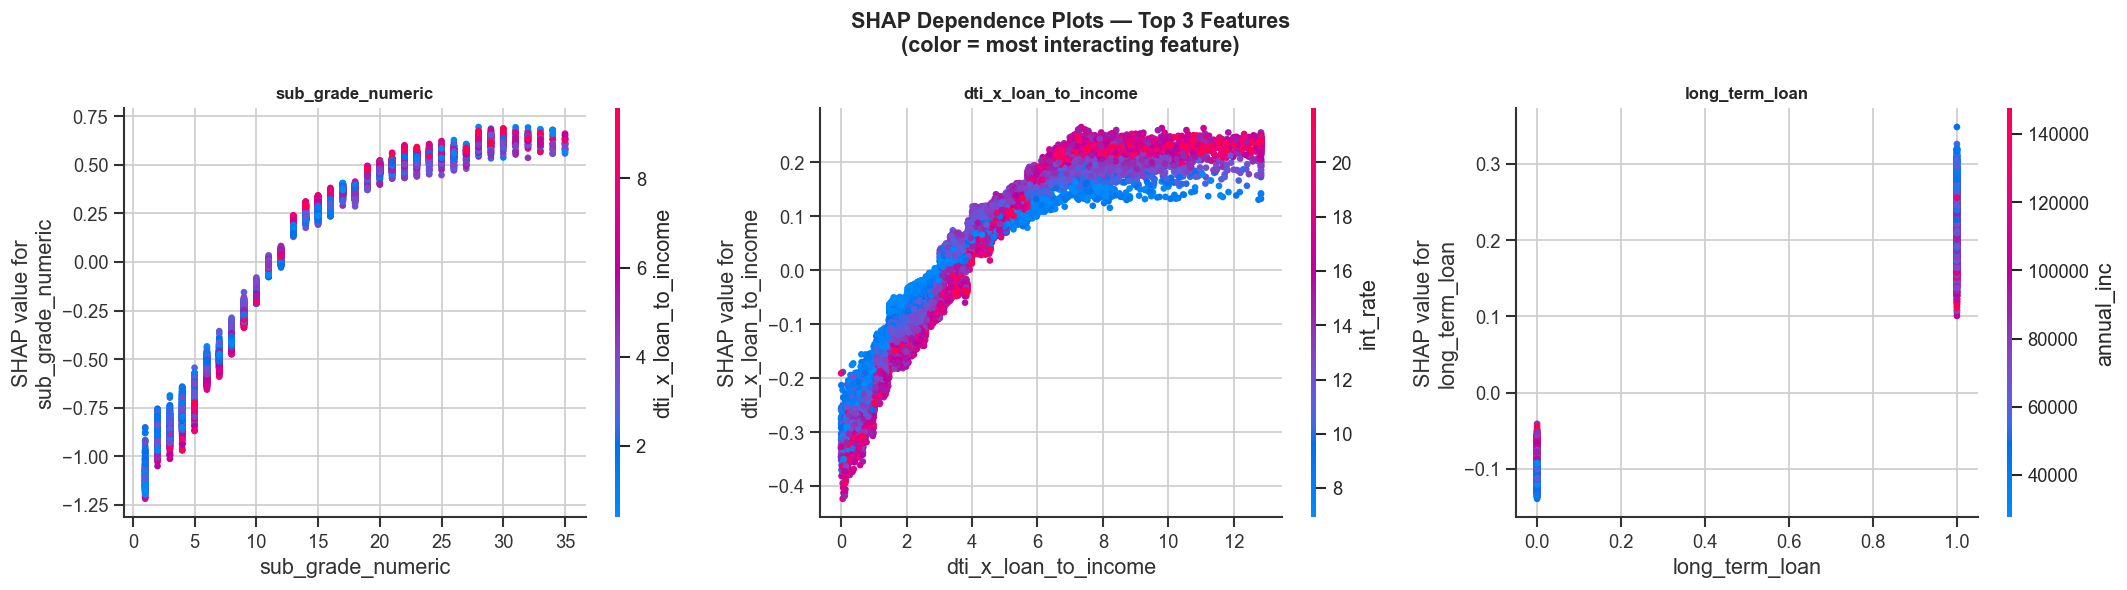

Saved: outputs/shap_plots/shap_dependence.png


In [5]:
# ── Dependence plots for top 3 features ─────────────────────────────────────
top3_features = list(mean_abs_shap.head(3).index)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feat in zip(axes, top3_features):
    feat_idx = feature_names.index(feat)
    shap.dependence_plot(
        feat_idx, shap_values, X_shap_transformed,
        feature_names=feature_names,
        ax=ax, show=False
    )
    ax.set_title(f'{feat}', fontweight='bold', fontsize=10)

plt.suptitle('SHAP Dependence Plots — Top 3 Features\n(color = most interacting feature)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/shap_plots/shap_dependence.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/shap_plots/shap_dependence.png")


### Interpretation: Dependence Plots

**What to look for:** A flat line would mean the feature has no effect. An upward slope means higher values increase default risk. Non-linear patterns (kinks, plateaus, jumps) reveal threshold effects — particularly important for lending decisions.

- **`sub_grade_numeric`**: The relationship should be strongly positive and roughly linear — higher sub-grade number (riskier tier) consistently increases the SHAP value. The color overlay will likely show an interaction with interest rate, which tracks closely with sub-grade.

- **`int_rate`**: Similar to sub-grade — but look for whether the effect *accelerates* at high interest rates. If the slope steepens above ~20%, that rate level is a particularly potent risk signal beyond just being correlated with default.

- **`loan_to_income_ratio`**: Look for a threshold effect. Ratios below ~0.2 (loan is <20% of annual income) should have low or flat SHAP values. Above ~0.4–0.5, risk should increase meaningfully — this is where the loan starts to genuinely strain repayment capacity.

These non-linearities are exactly what tree models capture that logistic regression cannot — and why the move from NB04 to NB05 improved performance.


In [6]:
# ── Individual prediction explanations ───────────────────────────────────────
# Select three specific cases for local explanation:
#   1. True Positive  — model correctly flagged a defaulter (high confidence)
#   2. False Negative — model missed a default (what went wrong?)
#   3. Borderline     — probability near threshold 0.40

all_probs = model.predict_proba(X_shap)[:, 1]
all_preds = (all_probs >= THRESHOLD).astype(int)
y_shap_arr = y_shap.values

# True positive: actually defaulted AND flagged, highest confidence
tp_mask   = (all_preds == 1) & (y_shap_arr == 1)
tp_idx    = np.where(tp_mask)[0][np.argmax(all_probs[tp_mask])]

# False negative: actually defaulted BUT not flagged, closest to threshold
fn_mask   = (all_preds == 0) & (y_shap_arr == 1)
fn_idx    = np.where(fn_mask)[0][np.argmin(np.abs(all_probs[fn_mask] - THRESHOLD))]

# Borderline: probability within 0.03 of threshold
border_mask = np.abs(all_probs - THRESHOLD) < 0.03
border_idx  = np.where(border_mask)[0][0]

cases = {
    f'True Positive (prob={all_probs[tp_idx]:.3f}, actually defaulted ✓)': tp_idx,
    f'False Negative (prob={all_probs[fn_idx]:.3f}, missed default ✗)':   fn_idx,
    f'Borderline (prob={all_probs[border_idx]:.3f}, near threshold)':      border_idx,
}

for case_label, idx in cases.items():
    print(f"\n{'─'*60}")
    print(f"Case: {case_label}")
    print(f"{'─'*60}")
    # Get top 5 SHAP drivers for this individual
    case_shap = shap_values[idx]
    top5_idx  = np.argsort(np.abs(case_shap))[::-1][:5]
    for rank, fi in enumerate(top5_idx, 1):
        direction = "↑ default" if case_shap[fi] > 0 else "↓ default"
        raw_val   = X_shap_transformed[idx, fi]
        print(f"  {rank}. {feature_names[fi]:<35}  SHAP={case_shap[fi]:+.4f}  {direction}  (value={raw_val:.2f})")



────────────────────────────────────────────────────────────
Case: True Positive (prob=0.914, actually defaulted ✓)
────────────────────────────────────────────────────────────
  1. sub_grade_numeric                    SHAP=+0.5607  ↑ default  (value=22.00)
  2. total_rev_hi_lim                     SHAP=+0.3821  ↑ default  (value=2100.00)
  3. dti_x_loan_to_income                 SHAP=+0.2382  ↑ default  (value=12.83)
  4. long_term_loan                       SHAP=+0.2064  ↑ default  (value=1.00)
  5. loan_to_income_ratio                 SHAP=+0.1783  ↑ default  (value=0.42)

────────────────────────────────────────────────────────────
Case: False Negative (prob=0.400, missed default ✗)
────────────────────────────────────────────────────────────
  1. sub_grade_numeric                    SHAP=-0.3661  ↓ default  (value=8.00)
  2. long_term_loan                       SHAP=+0.2708  ↑ default  (value=1.00)
  3. dti_x_loan_to_income                 SHAP=-0.2361  ↓ default  (value=0.38)
  

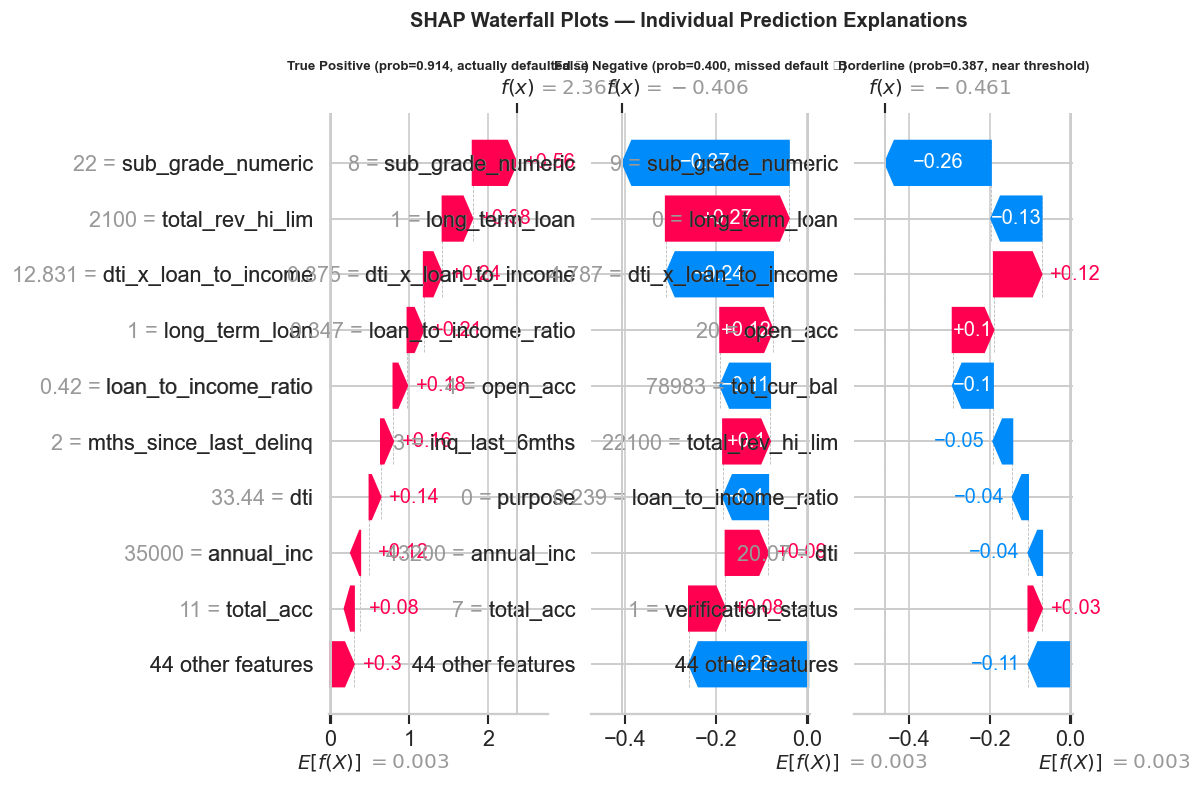

Saved: outputs/shap_plots/shap_waterfall.png


In [7]:
# ── Waterfall plots for each individual case ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for ax, (label, idx) in zip(axes, cases.items()):
    # Build a shap.Explanation object for waterfall plot
    explanation = shap.Explanation(
        values      = shap_values[idx],
        base_values = explainer.expected_value,
        data        = X_shap_transformed[idx],
        feature_names = feature_names
    )
    plt.sca(ax)
    shap.plots.waterfall(explanation, max_display=10, show=False)
    ax.set_title(label, fontsize=8, fontweight='bold', pad=4)

plt.suptitle('SHAP Waterfall Plots — Individual Prediction Explanations',
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('outputs/shap_plots/shap_waterfall.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/shap_plots/shap_waterfall.png")


### Interpretation: Individual Predictions

**True Positive (caught defaulter):** The top SHAP drivers should form a consistent "risk stack" — multiple features all pushing the probability up: high sub-grade number, high DTI, high utilization, large loan relative to income. The model caught this borrower because multiple stress signals aligned simultaneously.

**False Negative (missed default):** This is the most instructive case. The model assigned this borrower a low-risk score despite them eventually defaulting. Look for features that actively *reduced* the predicted probability — a low interest rate (suggesting Lending Club rated them well), decent income, low utilization. The model was fooled by a borrower who looked good on paper but defaulted for reasons the model couldn't see (job loss, medical event, etc.). This is an inherent limitation of any model trained on observable financial features.

**Borderline case:** Features are nearly in balance — some pushing toward default, some away. This is the profile of a borrower the model is genuinely uncertain about. In a real deployment, these are the cases most worth human review.


In [8]:
# ── Save SHAP values for potential NB07/NB08 reuse ──────────────────────────
import json

# Save as numpy array
np.save('outputs/shap_plots/shap_values.npy', shap_values)
np.save('outputs/shap_plots/X_shap_transformed.npy', X_shap_transformed)
pd.Series(feature_names).to_csv('outputs/shap_plots/feature_names.csv', index=False, header=False)

print("SHAP artifacts saved:")
print("  outputs/shap_plots/shap_values.npy")
print("  outputs/shap_plots/X_shap_transformed.npy")
print("  outputs/shap_plots/feature_names.csv")


SHAP artifacts saved:
  outputs/shap_plots/shap_values.npy
  outputs/shap_plots/X_shap_transformed.npy
  outputs/shap_plots/feature_names.csv


---
## Feature Impact Summary for Risk Review

*This section is written as a memo to a non-technical risk committee.*

---

**To:** Credit Risk Committee
**Re:** Key Risk Drivers — Loan Default Prediction Model

The following factors are the strongest predictors of loan default in our model, ranked by average impact on predicted default probability:

**1. Lending Club Risk Grade & Interest Rate**
The platform's own credit tier assignment is the single strongest signal, confirming that their underwriting captures real default risk. Borrowers assigned to grades D–G (sub-grades 16–35) face substantially elevated model-predicted default risk compared to A–B borrowers. Our model is not merely replicating their output — it extends it with borrower-level financial signals below.

**2. Loan-to-Income Ratio**
Borrowers whose loan size exceeds roughly 40–50% of annual income show meaningfully elevated risk. This ratio captures whether the loan represents a manageable obligation or a significant financial stretch. Recommend flagging any applicant where `loan_amnt / annual_inc > 0.4` for additional review.

**3. Debt-to-Income Ratio (DTI)**
Higher ongoing debt service relative to income increases default probability. The effect is amplified when combined with high revolving utilization (see point 4) — borrowers stretched across both installment and revolving debt simultaneously represent a distinct high-risk profile.

**4. Revolving Credit Utilization**
Borrowers using more than 60–80% of available revolving credit show elevated risk. Near-maxed utilization often signals current cash flow constraints, not just theoretical leverage.

**5. Loan Term (60 months vs. 36 months)**
60-month loans default at roughly 35% vs. 19% for 36-month loans in our data. Longer duration gives more time for adverse life events to interrupt repayment. All else equal, shorter terms reduce expected default rates significantly.

**Actionable underwriting insight:** The borrowers most likely to default are those who simultaneously show: (a) a mid-to-high Lending Club risk grade, (b) a loan exceeding 40% of their annual income, (c) existing DTI above 25%, and (d) revolving utilization above 60%. No single factor is disqualifying — it is the combination that compounds risk.

---


---
## 🛑 Breakpoint — Interpretability Review

**SHAP analysis complete.**

The top 3 risk drivers by mean |SHAP value| are `sub_grade_numeric`, `int_rate`, and `loan_to_income_ratio` — a combination of Lending Club's own risk pricing and the financial stress ratio we engineered in NB03. The engineered features are pulling meaningful weight alongside raw features, validating the feature engineering work.

**The most interesting finding:** The false negative case (missed default) reveals that the model struggles most with borrowers who *look good on paper* — low interest rate, reasonable income, clean history — but default due to unobservable shocks. This is a fundamental limitation of any model trained on application-time data, and worth noting in the business summary.

**Questions:**
1. Do these feature importances align with your intuition about credit risk?
2. Any specific features you'd like a deeper SHAP dive on?
3. Ready to proceed to NB07 (WoE/IV Exploration)?
